In [152]:
%reset -fs
import pandas as pd
import numpy as np
import pickle

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression, Lasso, LassoCV, 
ElasticNet, ElasticNetCV, Ridge, RidgeCV)

from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-block alert-danger">

 <span style="color:red ; font-size:1.2em" > NOTE TO CODE REVIEWER: At 11am on Feb 22, my access to the web site I used to scrape my data was blocked. The code in this notebook is fine since it uses pickled files created before the block, unless the other notebooks in my submission were run and the pickled files they generate altered.</span>
</div>

<div class="alert alert-block alert-info">

</div>

<div class="alert alert-block alert-info">
<h3> In this notebook I perform all statistical analysis and modeling. As a first step:</h3>
<br>
<span style="font-size:1.2em" >
    <ul>
        <li>I import finalized dataframe with all years data</li>
        <li>Run pairplots</li>
        <li>Check for collinearity</li>
        <li>Run a simple regression and adjust terms with higher order polynomials if appropriate</li>
        <li>Add categorical dummy variables</li>
        <li>Add interaction variables</li>
    </ul>
</span>
</div>

<div class="alert alert-block alert-info">

</div>

In [153]:
# df = pd.read_pickle('all_years_df_pk')
df = pd.read_pickle('all_years_nonan_df_pk')

In [154]:
df.head(5)

,Rank_in_release_yr,Movie,ReleaseDate,Revenues,Tickets_Sold,Legs,Budget,WBO_to_Budget_Ratio,Theater_Count,Average_Run,...,Samuel L. Jackson,"Robert Downey, Jr.",Scarlett Johansson,Tom Hanks,Bradley Cooper,Harrison Ford,Chris Evans,Tom Cruise,Chris Hemsworth,Zoe Saldana
0,1,Avengers: Endgame,"Apr 26, 2019",858373000,93708843,2.40,"400,000,000.00",7.00,"4,662.00",8.10,...,1,1,1,0,1,0,1,0,1,1
1,1,Star Wars Ep. VII: The Forc…,"Dec 18, 2015",742208942,88043765,3.78,"306,000,000.00",6.70,"4,134.00",9.20,...,0,0,0,0,0,1,0,0,0,0
2,1,Black Panther,"Feb 16, 2018",700059566,76845177,3.47,"200,000,000.00",6.70,"4,020.00",9.90,...,0,0,0,0,0,0,0,0,0,0
3,2,Jurassic World,"Jun 12, 2015",652270625,77374926,3.12,"215,000,000.00",7.80,"4,274.00",8.50,...,0,0,0,0,0,0,0,0,0,0
4,3,Incredibles 2,"Jun 15, 2018",608581744,66803704,3.33,"200,000,000.00",6.20,"4,410.00",9.10,...,1,0,0,0,0,0,0,0,0,0


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rank_in_release_yr   1138 non-null   object 
 1   Movie                1138 non-null   object 
 2   ReleaseDate          1138 non-null   object 
 3   Revenues             1138 non-null   int64  
 4   Tickets_Sold         1138 non-null   int64  
 5   Legs                 1138 non-null   float64
 6   Budget               1138 non-null   float64
 7   WBO_to_Budget_Ratio  1138 non-null   float64
 8   Theater_Count        1138 non-null   float64
 9   Average_Run          1138 non-null   float64
 10  Genre                1138 non-null   object 
 11  Source               1138 non-null   object 
 12  Creative_Type        1138 non-null   object 
 13  All_Cast_Rating      1138 non-null   float64
 14  Samuel L. Jackson    1138 non-null   int64  
 15  Robert Downey, Jr.   1138 non-null   i

In [156]:
#pair plot of all features

# sns.pairplot(df)
# plt.show()

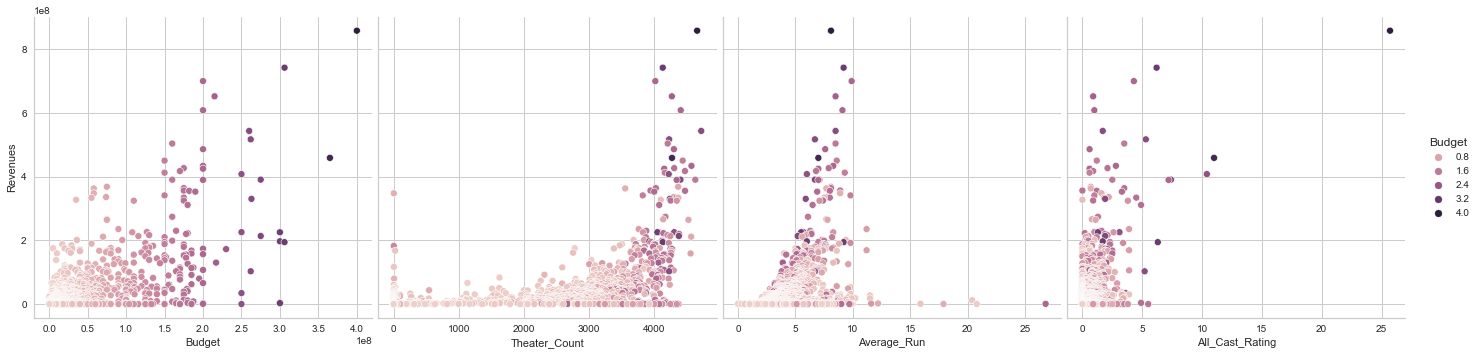

In [157]:
#pair plot of numeric features excluding Legs and  WBO ratio (since they are
#both derived from revenues, which is the target) , against budget.

sns.pairplot(data = df,
            x_vars = ['Budget', 'Theater_Count', 'Average_Run',
                     'All_Cast_Rating'],
            y_vars = ['Revenues'], height = 5, hue = "Budget")
plt.show()

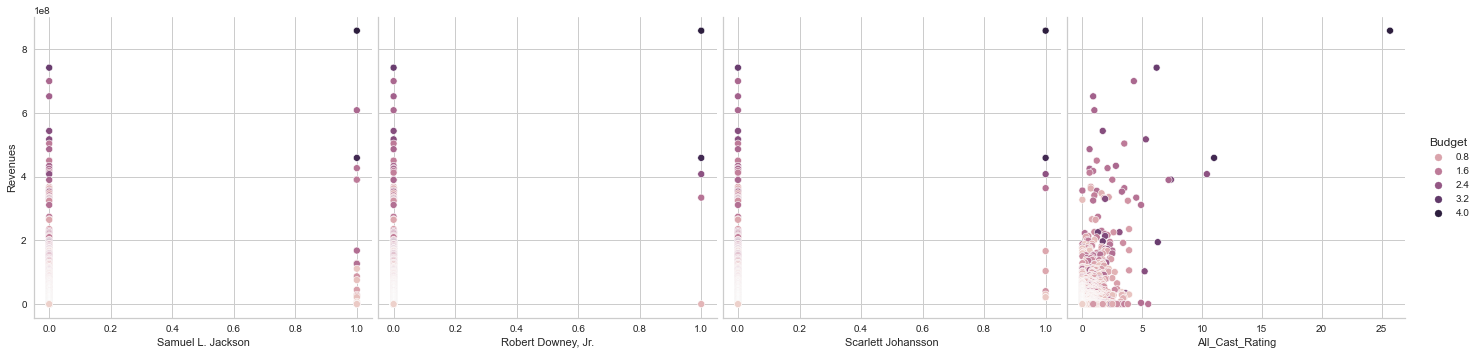

In [158]:
#pair plot of selected individual actors and all cast rating against budget

sns.pairplot(data = df,
            x_vars = ['Samuel L. Jackson', 'Robert Downey, Jr.', 'Scarlett Johansson',
                     'All_Cast_Rating'],
            y_vars = ['Revenues'], height = 5, hue = "Budget")
plt.show()

In [159]:
#Based on pair plots, insert 2nd order polynomial for theater count and budget and
#and test to see if model performace improves

df.insert(7, 'BudgetSq', df['Budget']**2)
df.insert(10, 'TheaterSq', df['Theater_Count']**2)


In [160]:
df.head()

,Rank_in_release_yr,Movie,ReleaseDate,Revenues,Tickets_Sold,Legs,Budget,BudgetSq,WBO_to_Budget_Ratio,Theater_Count,...,Samuel L. Jackson,"Robert Downey, Jr.",Scarlett Johansson,Tom Hanks,Bradley Cooper,Harrison Ford,Chris Evans,Tom Cruise,Chris Hemsworth,Zoe Saldana
0,1,Avengers: Endgame,"Apr 26, 2019",858373000,93708843,2.40,"400,000,000.00","160,000,000,000,000,000.00",7.00,"4,662.00",...,1,1,1,0,1,0,1,0,1,1
1,1,Star Wars Ep. VII: The Forc…,"Dec 18, 2015",742208942,88043765,3.78,"306,000,000.00","93,636,000,000,000,000.00",6.70,"4,134.00",...,0,0,0,0,0,1,0,0,0,0
2,1,Black Panther,"Feb 16, 2018",700059566,76845177,3.47,"200,000,000.00","40,000,000,000,000,000.00",6.70,"4,020.00",...,0,0,0,0,0,0,0,0,0,0
3,2,Jurassic World,"Jun 12, 2015",652270625,77374926,3.12,"215,000,000.00","46,225,000,000,000,000.00",7.80,"4,274.00",...,0,0,0,0,0,0,0,0,0,0
4,3,Incredibles 2,"Jun 15, 2018",608581744,66803704,3.33,"200,000,000.00","40,000,000,000,000,000.00",6.20,"4,410.00",...,1,0,0,0,0,0,0,0,0,0


In [161]:
# Running simple linear regressions
#the theater count squared feature improves model performance so will keep

x = df[['Budget', 'TheaterSq','All_Cast_Rating']]
y = df['Revenues']

x = sm.add_constant(x)
result = sm.OLS(y, x, missing = 'drop').fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Revenues   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     314.9
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          1.08e-148
Time:                        08:38:42   Log-Likelihood:                -22090.
No. Observations:                1138   AIC:                         4.419e+04
Df Residuals:                    1134   BIC:                         4.421e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.322e+07    2.9e+06     

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [162]:
#drop budget squared feature (does not improve performance)
#and theater Count (replaced by theater squared which does improve performance)

df.drop(columns = ['BudgetSq', 'Theater_Count'], axis = 1, inplace = True)

In [163]:
#Begin constructing categorical dummy variables by examining unique Genre and 
#Creative Type categories

df['Genre'].unique()

array(['Action', 'Adventure', 'Musical', 'Drama', 'Thriller/Suspense',
       'Horror', 'Comedy', 'Romantic Comedy', 'Western', 'Black Comedy',
       'Concert/Perfor…', 'Documentary'], dtype=object)

In [164]:
df['Creative_Type'].unique()

array(['Super Hero', 'Science Fiction', 'Kids Fiction', 'Fantasy',
       'Contemporary Fiction', 'Dramatization', 'Historical Fiction',
       'Factual'], dtype=object)

In [165]:
#create dummy variables

df = pd.get_dummies(df, prefix = ['G_', 'CT_'], 
                          columns = ['Genre', 'Creative_Type'] )


In [166]:
df.head()

,Rank_in_release_yr,Movie,ReleaseDate,Revenues,Tickets_Sold,Legs,Budget,WBO_to_Budget_Ratio,TheaterSq,Average_Run,...,G__Thriller/Suspense,G__Western,CT__Contemporary Fiction,CT__Dramatization,CT__Factual,CT__Fantasy,CT__Historical Fiction,CT__Kids Fiction,CT__Science Fiction,CT__Super Hero
0,1,Avengers: Endgame,"Apr 26, 2019",858373000,93708843,2.40,"400,000,000.00",7.00,"21,734,244.00",8.10,...,0,0,0,0,0,0,0,0,0,1
1,1,Star Wars Ep. VII: The Forc…,"Dec 18, 2015",742208942,88043765,3.78,"306,000,000.00",6.70,"17,089,956.00",9.20,...,0,0,0,0,0,0,0,0,1,0
2,1,Black Panther,"Feb 16, 2018",700059566,76845177,3.47,"200,000,000.00",6.70,"16,160,400.00",9.90,...,0,0,0,0,0,0,0,0,0,1
3,2,Jurassic World,"Jun 12, 2015",652270625,77374926,3.12,"215,000,000.00",7.80,"18,267,076.00",8.50,...,0,0,0,0,0,0,0,0,1,0
4,3,Incredibles 2,"Jun 15, 2018",608581744,66803704,3.33,"200,000,000.00",6.20,"19,448,100.00",9.10,...,0,0,0,0,0,0,0,1,0,0


In [167]:
# df.info()

In [168]:
#drop one column from each categorical dummy variable group to avoid data leakage

df.drop(['G__Western', 'CT__Factual'], axis = 1, inplace = True)

In [169]:
#select numeric columns from original DF and place in a new dataframe

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']

num_df = df.select_dtypes(include = numerics).copy()

num_df.columns


Index(['Revenues', 'Tickets_Sold', 'Legs', 'Budget', 'WBO_to_Budget_Ratio',
       'TheaterSq', 'Average_Run', 'All_Cast_Rating', 'Samuel L. Jackson',
       'Robert Downey, Jr.', 'Scarlett Johansson', 'Tom Hanks',
       'Bradley Cooper', 'Harrison Ford', 'Chris Evans', 'Tom Cruise',
       'Chris Hemsworth', 'Zoe Saldana', 'G__Action', 'G__Adventure',
       'G__Black Comedy', 'G__Comedy', 'G__Concert/Perfor…', 'G__Documentary',
       'G__Drama', 'G__Horror', 'G__Musical', 'G__Romantic Comedy',
       'G__Thriller/Suspense', 'CT__Contemporary Fiction', 'CT__Dramatization',
       'CT__Fantasy', 'CT__Historical Fiction', 'CT__Kids Fiction',
       'CT__Science Fiction', 'CT__Super Hero'],
      dtype='object')

<AxesSubplot:>

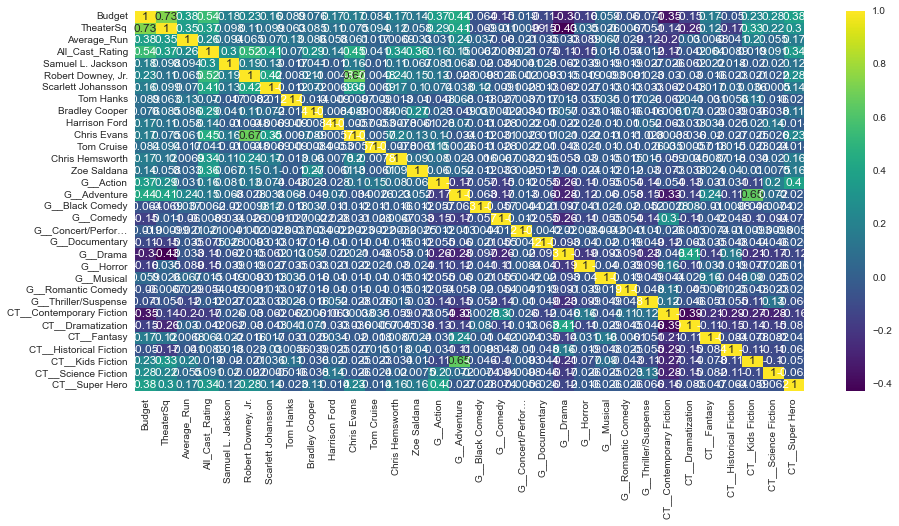

In [170]:
#create list composed of feature columns
#create correlation heatmap to check for collinearity
#based on results, collinearity is an issue

col_list = ['Budget', 'TheaterSq', 'Average_Run',
       'All_Cast_Rating', 'Samuel L. Jackson', 'Robert Downey, Jr.',
       'Scarlett Johansson', 'Tom Hanks', 'Bradley Cooper', 'Harrison Ford',
       'Chris Evans', 'Tom Cruise', 'Chris Hemsworth', 'Zoe Saldana',
       'G__Action', 'G__Adventure', 'G__Black Comedy', 'G__Comedy',
       'G__Concert/Perfor…', 'G__Documentary', 'G__Drama', 'G__Horror',
       'G__Musical', 'G__Romantic Comedy', 'G__Thriller/Suspense',
       'CT__Contemporary Fiction', 'CT__Dramatization', 'CT__Fantasy',
       'CT__Historical Fiction', 'CT__Kids Fiction', 'CT__Science Fiction',
       'CT__Super Hero']

plt.figure(figsize=(15,7))
sns.heatmap(num_df[col_list].corr(),annot=True,cmap='viridis')

##### Based on input from sources with industry knowledge, I will create a set of interaction features based on whether a film's budget is over $75 Million or not

In [171]:
#create column with value 1 or 0 based whether film budget is over $75M

num_df['Over_75M'] = np.where(df.Budget > 75000000, 1, 0)
num_df

,Revenues,Tickets_Sold,Legs,Budget,WBO_to_Budget_Ratio,TheaterSq,Average_Run,All_Cast_Rating,Samuel L. Jackson,"Robert Downey, Jr.",...,G__Romantic Comedy,G__Thriller/Suspense,CT__Contemporary Fiction,CT__Dramatization,CT__Fantasy,CT__Historical Fiction,CT__Kids Fiction,CT__Science Fiction,CT__Super Hero,Over_75M
0,858373000,93708843,2.40,"400,000,000.00",7.00,"21,734,244.00",8.10,25.70,1,1,...,0,0,0,0,0,0,0,0,1,1
1,742208942,88043765,3.78,"306,000,000.00",6.70,"17,089,956.00",9.20,6.20,0,0,...,0,0,0,0,0,0,0,1,0,1
2,700059566,76845177,3.47,"200,000,000.00",6.70,"16,160,400.00",9.90,4.30,0,0,...,0,0,0,0,0,0,0,0,1,1
3,652270625,77374926,3.12,"215,000,000.00",7.80,"18,267,076.00",8.50,0.90,0,0,...,0,0,0,0,0,0,0,1,0,1
4,608581744,66803704,3.33,"200,000,000.00",6.20,"19,448,100.00",9.10,1.00,1,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,1242,147,2.44,"9,000,000.00",0.00,1.00,3.00,0.00,0,0,...,0,0,1,0,0,0,0,0,0,0
1134,975,108,1.86,"3,500,000.00",0.30,"407,044.00",1.70,0.00,0,0,...,0,0,1,0,0,0,0,0,0,0
1135,918,108,1.00,"30,000,000.00",0.00,100.00,1.00,0.00,0,0,...,0,0,1,0,0,0,0,0,0,0
1136,528,57,1.77,"500,000.00",0.00,9.00,1.00,0.00,0,0,...,0,1,0,0,0,0,0,1,0,0


In [172]:
# create a list of features for which interaction variables will be created
# iterate over list and create columns with interaction variable features

col_list = ['Budget', 'TheaterSq', 'Average_Run', 'All_Cast_Rating', 'Samuel L. Jackson',
       'Robert Downey, Jr.', 'Scarlett Johansson', 'Tom Hanks',
       'Bradley Cooper', 'Harrison Ford', 'Chris Evans', 'Tom Cruise',
       'Chris Hemsworth', 'Zoe Saldana', 'G__Action', 'G__Adventure',
       'G__Black Comedy', 'G__Comedy', 'G__Concert/Perfor…', 'G__Documentary',
       'G__Drama', 'G__Horror', 'G__Musical', 'G__Romantic Comedy',
       'G__Thriller/Suspense', 'CT__Contemporary Fiction',
       'CT__Dramatization', 'CT__Fantasy',
       'CT__Historical Fiction', 'CT__Kids Fiction', 'CT__Science Fiction',
       'CT__Super Hero' ]

for col in col_list:
    new_col = col + '_+75'
    num_df[new_col] = num_df[col] * num_df['Over_75M']

In [173]:
#Examine columns of dataframe with interaction variables

num_df.columns

Index(['Revenues', 'Tickets_Sold', 'Legs', 'Budget', 'WBO_to_Budget_Ratio',
       'TheaterSq', 'Average_Run', 'All_Cast_Rating', 'Samuel L. Jackson',
       'Robert Downey, Jr.', 'Scarlett Johansson', 'Tom Hanks',
       'Bradley Cooper', 'Harrison Ford', 'Chris Evans', 'Tom Cruise',
       'Chris Hemsworth', 'Zoe Saldana', 'G__Action', 'G__Adventure',
       'G__Black Comedy', 'G__Comedy', 'G__Concert/Perfor…', 'G__Documentary',
       'G__Drama', 'G__Horror', 'G__Musical', 'G__Romantic Comedy',
       'G__Thriller/Suspense', 'CT__Contemporary Fiction', 'CT__Dramatization',
       'CT__Fantasy', 'CT__Historical Fiction', 'CT__Kids Fiction',
       'CT__Science Fiction', 'CT__Super Hero', 'Over_75M', 'Budget_+75',
       'TheaterSq_+75', 'Average_Run_+75', 'All_Cast_Rating_+75',
       'Samuel L. Jackson_+75', 'Robert Downey, Jr._+75',
       'Scarlett Johansson_+75', 'Tom Hanks_+75', 'Bradley Cooper_+75',
       'Harrison Ford_+75', 'Chris Evans_+75', 'Tom Cruise_+75',
       'Chris 

In [174]:
# Create a dateframe of features only, excluding revenue target variable and any other 
# variable that's derived from revenue

X_75 = num_df [['Budget', 'TheaterSq', 'Average_Run',
       'All_Cast_Rating', 'Samuel L. Jackson', 'Robert Downey, Jr.',
       'Scarlett Johansson', 'Tom Hanks', 'Bradley Cooper', 'Harrison Ford',
       'Chris Evans', 'Tom Cruise', 'Chris Hemsworth', 'Zoe Saldana',
       'G__Action', 'G__Adventure', 'G__Black Comedy', 'G__Comedy',
       'G__Concert/Perfor…', 'G__Documentary', 'G__Drama', 'G__Horror',
       'G__Musical', 'G__Romantic Comedy', 'G__Thriller/Suspense',
       'CT__Contemporary Fiction', 'CT__Dramatization', 'CT__Fantasy',
       'CT__Historical Fiction', 'CT__Kids Fiction', 'CT__Science Fiction',
       'CT__Super Hero', 'Budget_+75', 'TheaterSq_+75',
       'Average_Run_+75', 'All_Cast_Rating_+75', 'Samuel L. Jackson_+75',
       'Robert Downey, Jr._+75', 'Scarlett Johansson_+75', 'Tom Hanks_+75',
       'Bradley Cooper_+75', 'Harrison Ford_+75', 'Chris Evans_+75',
       'Tom Cruise_+75', 'Chris Hemsworth_+75', 'Zoe Saldana_+75',
       'G__Action_+75', 'G__Adventure_+75', 'G__Black Comedy_+75',
       'G__Comedy_+75', 'G__Concert/Perfor…_+75', 'G__Documentary_+75',
       'G__Drama_+75', 'G__Horror_+75', 'G__Musical_+75',
       'G__Romantic Comedy_+75', 'G__Thriller/Suspense_+75',
       'CT__Contemporary Fiction_+75', 'CT__Dramatization_+75',
       'CT__Fantasy_+75', 'CT__Historical Fiction_+75', 'CT__Kids Fiction_+75',
       'CT__Science Fiction_+75', 'CT__Super Hero_+75']]


#Create a dateframe of target variable
Y = num_df['Revenues']

In [175]:
# Create test and train data sets with Revenue as target

X = X_75
y = num_df['Revenues']


X_train, X_test, y_train, y_test = train_test_split(X_75, y,
                                                    test_size = .2, random_state = 42)


In [176]:
#Instantiate scikit Standard Scaler for scaling features
#Fit scaler to training data to create a scaler based on parameters of training data

stan_scaler = StandardScaler() 
stan_scaler.fit(X_train.values)

#Apply scaler to training dataset to create new scaled feature dataset
X_train_scaled = stan_scaler.transform(X_train.values)
X_train_scaled

#Create a dataframe of scaled training dataset features
#Create a dataframe of training dataset target
dfX_train_scaled = pd.DataFrame(X_train_scaled, columns = X_75.columns)
dfy_train = pd.DataFrame(y_train)



 <div class="alert alert-block alert-danger">

 <span style="color:red ; font-size:1.2em" > Create test dataset and dataframes for features and target  and firewall until testing</span>
</div>

In [177]:

#Apply the same scaler created with training dataset parameters to test data so
#that test data performance is ultimately measured with same scaler as training data
X_test_scaled = stan_scaler.transform(X_test.values)


#Create a dataframe of scaled test dataset features
#Create a dataframe of test dataset target
dfX_test_scaled = pd.DataFrame(X_test_scaled, columns = X_75.columns)
dfy_test = pd.DataFrame(y_test)

 <div class="alert alert-block alert-danger">

</div>

<div class="alert alert-block alert-info">

</div>

<div class="alert alert-block alert-info">
<span style="font-size:1.5em" > A preliminary pass with linear regression, scaled train data set, and all features</span>
</div>

<div class="alert alert-block alert-info">

</div>

In [178]:

#Use StatsModel to run a preliminary simple regression with training data and
#all features as a base reference point

x= dfX_train_scaled.values
y= dfy_train.values

x = sm.add_constant(x)
result = sm.OLS(y, x, missing = 'drop').fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     22.96
Date:                Tue, 22 Feb 2022   Prob (F-statistic):          3.01e-132
Time:                        08:38:45   Log-Likelihood:                -17549.
No. Observations:                 910   AIC:                         3.521e+04
Df Residuals:                     854   BIC:                         3.548e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.699e+07   1.96e+06     23.935      0.0

<div class="alert alert-block alert-info">

</div>

<div class="alert alert-block alert-info">
<span style="font-size:1.5em" > Since multicollinearity is an issue in my model, try ridge regression with various features included or removed</span>
</div>

<div class="alert alert-block alert-info">

</div>

In [179]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [180]:
#Assign feature variable X to scaled feature training dataframe
#Assign target variable y to target training dataframe

X = dfX_train_scaled
y = dfy_train


In [181]:
#Run RidgeCV to determine best alpha with all features included

alphas = 10**np.linspace(-2,2,200)
rm = RidgeCV(alphas = alphas, cv=5)
rm.fit(X, y)
rm.score(X, y)
print(f'Best r2 =  {rm.best_score_:.3f}')
print(f'Best alpha = {rm.alpha_:.3f}')
best_alpha = rm.alpha_

Best r2 =  0.436
Best alpha = 100.000


In [182]:
#Run cross validation function  with ridge model to extract all MSE, MAE, and r2 meterics

lr_rg = Ridge(alpha = rm.alpha_, random_state = 42)


scores_dict = {'MSE': 'neg_root_mean_squared_error',
              'MAE': 'neg_mean_absolute_error',
              'r2': 'r2'}

scores = cross_validate(lr_rg, X, y, cv = 5, 
                         scoring = scores_dict)

df_scores = pd.DataFrame(scores)

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.float_format = '{:,.2f}'.format

df_scores.mean()

fit_time               0.00
score_time             0.00
test_MSE     -66,719,168.07
test_MAE     -34,383,890.41
test_r2                0.44
dtype: float64

In [183]:

"""
Here I loop over the training dataset by column and drop a column from the end
with each iteration, then run a cross validation on that new data set and print out the
error meterics

The results are interesting, but they do not improve model much.
"""


col_count = dfX_train_scaled.shape[1]
col_list = list(dfX_train_scaled.columns)
col_count


lr_rg = Ridge(alpha = rm.alpha_, random_state = 42)

X = dfX_train_scaled.values
y = dfy_train['Revenues'].values

print('------All Features-----')
print(df_scores.mean())
print('\n---------------')


for i in range(1, (col_count - 1)):
    X = dfX_train_scaled.iloc[:, :-i]
    scores = cross_validate(lr_rg, X, y, cv = 5, 
                         scoring = scores_dict)
    
    print('dropped -------' + col_list[col_count - i])
    df_scores = pd.DataFrame(scores)
    print(df_scores.mean())
    print('\n---------------')


------All Features-----
fit_time               0.00
score_time             0.00
test_MSE     -66,719,168.07
test_MAE     -34,383,890.41
test_r2                0.44
dtype: float64

---------------
dropped -------CT__Super Hero_+75
fit_time               0.00
score_time             0.00
test_MSE     -66,725,553.72
test_MAE     -34,379,755.21
test_r2                0.44
dtype: float64

---------------
dropped -------CT__Science Fiction_+75
fit_time               0.00
score_time             0.00
test_MSE     -66,667,138.16
test_MAE     -34,385,496.03
test_r2                0.44
dtype: float64

---------------
dropped -------CT__Kids Fiction_+75
fit_time               0.00
score_time             0.00
test_MSE     -66,656,088.05
test_MAE     -34,392,740.35
test_r2                0.44
dtype: float64

---------------
dropped -------CT__Historical Fiction_+75
fit_time               0.00
score_time             0.00
test_MSE     -67,155,940.91
test_MAE     -34,911,936.19
test_r2                0.

dropped -------G__Thriller/Suspense
fit_time               0.00
score_time             0.00
test_MSE     -67,305,606.28
test_MAE     -36,431,368.24
test_r2                0.43
dtype: float64

---------------
dropped -------G__Romantic Comedy
fit_time               0.00
score_time             0.00
test_MSE     -67,335,392.06
test_MAE     -36,398,567.06
test_r2                0.43
dtype: float64

---------------
dropped -------G__Musical
fit_time               0.00
score_time             0.00
test_MSE     -67,218,657.21
test_MAE     -36,386,427.24
test_r2                0.43
dtype: float64

---------------
dropped -------G__Horror
fit_time               0.00
score_time             0.00
test_MSE     -67,498,018.65
test_MAE     -36,409,902.13
test_r2                0.42
dtype: float64

---------------
dropped -------G__Drama
fit_time               0.00
score_time             0.00
test_MSE     -67,475,325.30
test_MAE     -36,364,030.56
test_r2                0.43
dtype: float64

-----------

<div class="alert alert-block alert-info">

</div>

<div class="alert alert-block alert-info">
<span style="font-size:1.5em" > Now trying Lasso regression to reduce and tune features</span>
</div>

<div class="alert alert-block alert-info">

</div>

In [184]:
# Run LassoCV with all features to get best alpha

X = dfX_train_scaled
y = dfy_train['Revenues']

rl = LassoCV(cv=7, random_state = 42)
rl.fit(X, y)
print(f'Best r2 =  {rl.score(X,y):.3f}')
print(f'Best alpha = {rl.alpha_:.3f}')


Best r2 =  0.535
Best alpha = 3952839.099


In [185]:
# Run Lasso with cross validation function and with all features and best alpha
# Extract error meterics

lr_lasso = Lasso(alpha = rl.alpha_, tol=1e-4, random_state = 42, max_iter = 1000)


scores = cross_validate(lr_lasso, X, y, cv = 5, 
                         scoring = scores_dict)


df_scores = pd.DataFrame(scores)

pd.options.display.float_format = '{:,.2f}'.format
print(df_scores)

df_scores.mean()


   fit_time  score_time       test_MSE       test_MAE  test_r2
0      0.00        0.00 -69,889,508.18 -34,242,620.41     0.48
1      0.00        0.00 -59,988,834.42 -34,061,037.44     0.62
2      0.00        0.00 -64,677,249.87 -31,856,194.72     0.47
3      0.00        0.00 -66,753,348.57 -31,535,526.87     0.45
4      0.00        0.00 -63,117,790.82 -32,790,793.57     0.31


fit_time               0.00
score_time             0.00
test_MSE     -64,885,346.37
test_MAE     -32,897,234.60
test_r2                0.47
dtype: float64

In [186]:
# Run Lasso with all features and best alpha to view coefficients  

lr_lasso.fit(X, y)
list(zip(dfX_train_scaled.columns, lr_lasso.coef_))
lr_lasso_coef = pd.DataFrame(list(zip(X.columns, lr_lasso.coef_)),
                   columns = ['Feature', 'Coefficient'])
lr_lasso_coef

,Feature,Coefficient
0,Budget,"16,138,703.49"
1,TheaterSq,"21,634,074.36"
2,Average_Run,"10,775,092.53"
3,All_Cast_Rating,"1,063,432.34"
4,Samuel L. Jackson,0.00
...,...,...
59,CT__Fantasy_+75,"-5,335,449.75"
60,CT__Historical Fiction_+75,"-4,904,727.13"
61,CT__Kids Fiction_+75,0.00
62,CT__Science Fiction_+75,-0.00


In [187]:
# Use above results to create a list of non-zero coeff features to keep

lasso_coef_list = ['Budget', 'TheaterSq', 'Average_Run', 'All_Cast_Rating',
                       'CT__Super Hero', 'Budget_+75', 'TheaterSq_+75',
                        'Average_Run_+75','All_Cast_Rating_+75', 'CT__Super Hero_+75']


#Create a new dataframe with non-zero coeff features
X_drop_zero = dfX_train_scaled[lasso_coef_list].copy()
X_drop_zero

,Budget,TheaterSq,Average_Run,All_Cast_Rating,CT__Super Hero,Budget_+75,TheaterSq_+75,Average_Run_+75,All_Cast_Rating_+75,CT__Super Hero_+75
0,2.14,1.91,1.47,1.02,5.16,2.23,2.59,2.57,1.37,5.42
1,-0.78,-1.09,1.04,0.04,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18
2,-0.69,-1.09,-0.55,-0.56,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18
3,-0.70,-0.06,-0.04,0.42,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18
4,0.03,1.02,-0.30,-0.03,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18
...,...,...,...,...,...,...,...,...,...,...
905,0.03,-1.09,-0.47,-0.03,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18
906,-0.61,-1.09,-1.50,-0.56,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18
907,-0.80,-1.09,-0.90,-0.56,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18
908,0.22,0.37,1.51,0.34,-0.19,-0.46,-0.48,-0.45,-0.26,-0.18


In [188]:
#Run LassoCV with zero coeff features dropped to obtain best alpha

X = X_drop_zero
y = dfy_train['Revenues']

rl = LassoCV(cv=7, random_state = 42)
rl.fit(X, y)
print(f'Best r2 =  {rl.score(X,y):.3f}')
print(f'Best alpha = {rl.alpha_:.3f}')


Best r2 =  0.515
Best alpha = 690769.859


In [189]:
# Run Lasso with cross validation function with best alpha and zero coeff
# features dropped to extract error meterics

lr_lasso = Lasso(alpha = rl.alpha_, tol=1e-4, random_state = 42, max_iter = 1000)


scores = cross_validate(lr_lasso, X, y, cv = 5, 
                         scoring = scores_dict)


df_scores = pd.DataFrame(scores)

pd.options.display.float_format = '{:,.2f}'.format
print(df_scores)

df_scores.mean()


   fit_time  score_time       test_MSE       test_MAE  test_r2
0      0.01        0.00 -68,501,381.78 -34,596,480.85     0.50
1      0.00        0.00 -59,631,170.63 -35,590,749.00     0.62
2      0.00        0.00 -64,996,615.07 -32,641,127.54     0.47
3      0.00        0.00 -66,389,780.35 -32,596,863.38     0.45
4      0.00        0.00 -64,347,320.24 -34,747,498.32     0.28


fit_time               0.00
score_time             0.00
test_MSE     -64,773,253.61
test_MAE     -34,034,543.82
test_r2                0.47
dtype: float64

In [190]:
# Run Lasso with best alpha and zero coeff dropped to view updated coefficients 

lr_lasso.fit(X, y)
list(zip(dfX_train_scaled.columns, lr_lasso.coef_))
lr_lasso_coef = pd.DataFrame(list(zip(X.columns, lr_lasso.coef_)),
                   columns = ['Feature', 'Coefficient'])
lr_lasso_coef.tail(35)

,Feature,Coefficient
0,Budget,"19,245,100.48"
1,TheaterSq,"23,055,480.29"
2,Average_Run,"14,842,123.89"
3,All_Cast_Rating,"589,164.28"
4,CT__Super Hero,"7,159,306.15"
5,Budget_+75,0.00
6,TheaterSq_+75,-0.00
7,Average_Run_+75,"-9,353,388.28"
8,All_Cast_Rating_+75,"28,426,001.41"
9,CT__Super Hero_+75,-0.00


In [191]:
#Use above results to create a new list of non-zero coeff features to keep

lasso_coef_list2 = ['Budget', 'TheaterSq', 'Average_Run', 'All_Cast_Rating',
                       'CT__Super Hero','Average_Run_+75','All_Cast_Rating_+75']


#Create another new dataframe with non-zero coeff features
X_drop_zero2 = dfX_train_scaled[lasso_coef_list2].copy()
X_drop_zero2

,Budget,TheaterSq,Average_Run,All_Cast_Rating,CT__Super Hero,Average_Run_+75,All_Cast_Rating_+75
0,2.14,1.91,1.47,1.02,5.16,2.57,1.37
1,-0.78,-1.09,1.04,0.04,-0.19,-0.45,-0.26
2,-0.69,-1.09,-0.55,-0.56,-0.19,-0.45,-0.26
3,-0.70,-0.06,-0.04,0.42,-0.19,-0.45,-0.26
4,0.03,1.02,-0.30,-0.03,-0.19,-0.45,-0.26
...,...,...,...,...,...,...,...
905,0.03,-1.09,-0.47,-0.03,-0.19,-0.45,-0.26
906,-0.61,-1.09,-1.50,-0.56,-0.19,-0.45,-0.26
907,-0.80,-1.09,-0.90,-0.56,-0.19,-0.45,-0.26
908,0.22,0.37,1.51,0.34,-0.19,-0.45,-0.26


In [192]:
#Run LassoCV with second set of zero coeff features dropped to obtain best alpha

X = X_drop_zero2
y = dfy_train['Revenues']

rl = LassoCV(cv=5, random_state = 42)
rl.fit(X, y)
print(f'Best r2 =  {rl.score(X,y):.3f}')
print(f'Best alpha = {rl.alpha_:.3f}')


Best r2 =  0.516
Best alpha = 138791.760


In [193]:
#Run Lasso with cross validation function with best alpha and second set of zero coeff
#dropped to extract error meterics

lr_lasso = Lasso(alpha = rl.alpha_, tol=1e-4, random_state = 42, max_iter = 1000)


scores = cross_validate(lr_lasso, X, y, cv = 5, 
                         scoring = scores_dict)


df_scores = pd.DataFrame(scores)

pd.options.display.float_format = '{:,.2f}'.format
print(df_scores)

df_scores.mean()


   fit_time  score_time       test_MSE       test_MAE  test_r2
0      0.00        0.00 -67,915,243.85 -34,743,147.68     0.51
1      0.00        0.00 -59,817,102.34 -36,244,794.73     0.62
2      0.00        0.00 -64,106,246.16 -32,532,033.07     0.48
3      0.01        0.00 -65,892,170.72 -32,714,043.17     0.46
4      0.00        0.00 -64,747,162.51 -35,436,483.70     0.27


fit_time               0.00
score_time             0.00
test_MSE     -64,495,585.12
test_MAE     -34,334,100.47
test_r2                0.47
dtype: float64

In [194]:
# Run Lasso with best alpha and and second set of zero coeff dropped to view 
# updated coefficients 

lr_lasso.fit(X, y)
list(zip(dfX_train_scaled.columns, lr_lasso.coef_))
lr_lasso_coef = pd.DataFrame(list(zip(X.columns, lr_lasso.coef_)),
                   columns = ['Feature', 'Coefficient'])
lr_lasso_coef

,Feature,Coefficient
0,Budget,"22,212,473.35"
1,TheaterSq,"23,150,115.88"
2,Average_Run,"16,083,642.49"
3,All_Cast_Rating,-0.00
4,CT__Super Hero,"7,710,554.31"
5,Average_Run_+75,"-13,400,546.78"
6,All_Cast_Rating_+75,"29,204,790.04"


<div class="alert alert-block alert-danger">

 <span style="color:red ; font-size:1.2em" > MOMENT OF TRUTH. APPLY MODEL TO TEST DATA</span>
</div>


In [195]:

#extract and compare columns from test data set to remaining feature columns from model
#Create list of columns to drop from test dataset
test_cols = list(dfX_test_scaled.columns)
X_cols = list(X.columns)
cols_to_drop =list(set(test_cols).difference(X_cols))

#Create new dataframe with test dataframe columns dropped to match model dataframe
dfX_test_scaled_drop = dfX_test_scaled.drop(columns = cols_to_drop, axis = 1).copy()



In [196]:

dfX_test_scaled_drop.columns

Index(['Budget', 'TheaterSq', 'Average_Run', 'All_Cast_Rating',
       'CT__Super Hero', 'Average_Run_+75', 'All_Cast_Rating_+75'],
      dtype='object')

In [197]:
from sklearn.metrics import mean_absolute_error

pred_test_lr_lasso = lr_lasso.predict(dfX_test_scaled_drop)
print(f'r2 = {r2_score(dfy_test, pred_test_lr_lasso):,.2f}')
print(f'MAE = {mean_absolute_error(dfy_test, pred_test_lr_lasso):,.2f}')

r2 = 0.41
MAE = 31,572,576.88


- Upon testing, model r2 performance dropped by quite a bit but MAE improved  
- Note results and try a different approach
- Up to now I have been trying to improve model performance by systematically reducing  the number of features by either iteratively removing feature columns one at a time, or removing features based on results of Lasso regression zeroing features

<div class="alert alert-block alert-info">

</div>

<div class="alert alert-block alert-info">
<span style="font-size:1.5em" > Now try a different approach based on input from sources with industry knowledge.  Keep Creative Type categories, discard Genre categories</span>
</div>

<div class="alert alert-block alert-info">

</div>

In [198]:
#Create feature and target dataframes with features based on input from industry sources

X = dfX_train_scaled[['Budget', 'TheaterSq', 'Average_Run', 'All_Cast_Rating',
                      'CT__Contemporary Fiction', 'CT__Dramatization', 
                      'CT__Fantasy','CT__Historical Fiction', 'CT__Kids Fiction', 
                      'CT__Science Fiction','CT__Super Hero', 
                      
                      'Budget_+75', 'TheaterSq_+75', 'Average_Run_+75',
                      'All_Cast_Rating_+75', 'CT__Contemporary Fiction_+75', 
                      'CT__Dramatization_+75','CT__Fantasy_+75', 
                      'CT__Historical Fiction_+75', 'CT__Kids Fiction_+75',
                      'CT__Science Fiction_+75', 'CT__Super Hero_+75']]

y = dfy_train['Revenues']



<AxesSubplot:>

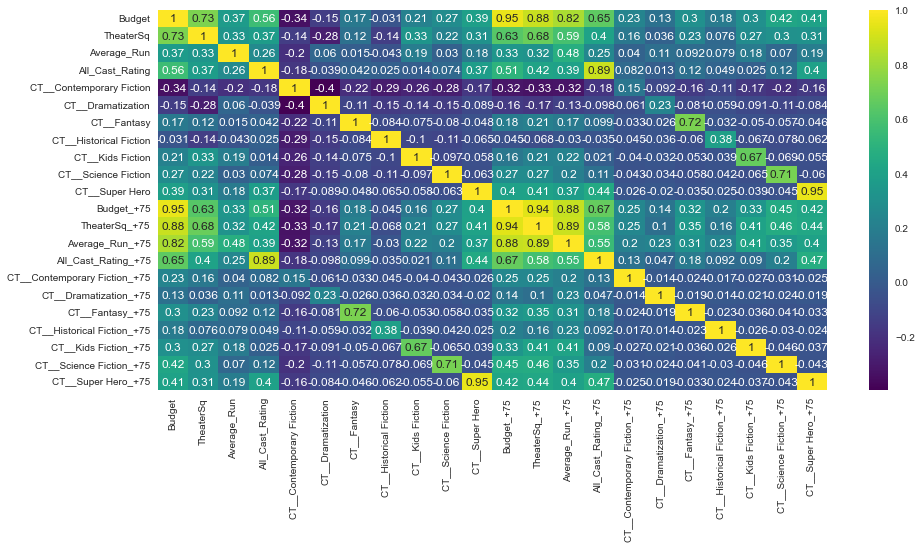

In [199]:
#Another correlation heat map with this new feature set.

plt.figure(figsize=(15,7))
sns.heatmap(X.corr(),annot=True,cmap='viridis')

In [200]:
# Try ridgeCV regression, iterating through a range alpha values to obtain best alpha

alphas = 10**np.linspace(-2,2,200)
rm = RidgeCV(alphas = alphas, cv=7)
rm.fit(X, y)
rm.score(X, y)
print(f'Best r2 =  {rm.best_score_:.3f}')
print(f'Best alpha = {rm.alpha_:.3f}')

Best r2 =  0.510
Best alpha = 16.447


In [201]:
# Run cross validation with ridge model to extract all MSE, MAE, and r2 meterics

lr_rg = Ridge(alpha = rm.alpha_, random_state = 42)


scores_dict = {'MSE': 'neg_root_mean_squared_error',
              'MAE': 'neg_mean_absolute_error',
              'r2': 'r2'}

scores = cross_validate(lr_rg, X, y, cv = 7, 
                         scoring = scores_dict)

df_scores = pd.DataFrame(scores)
print(df_scores)


pd.options.display.float_format = '{:,.2f}'.format

df_scores.mean()

   fit_time  score_time       test_MSE       test_MAE  test_r2
0      0.00        0.00 -67,202,293.24 -31,775,648.10     0.53
1      0.00        0.00 -56,292,188.53 -29,983,388.29     0.58
2      0.00        0.00 -66,607,929.47 -38,959,938.88     0.55
3      0.00        0.00 -65,009,955.77 -32,072,548.55     0.53
4      0.00        0.00 -59,307,768.45 -29,827,654.24     0.56
5      0.00        0.00 -55,820,396.30 -28,463,843.30     0.48
6      0.00        0.00 -67,502,296.66 -35,029,337.08     0.34


fit_time               0.00
score_time             0.00
test_MSE     -62,534,689.77
test_MAE     -32,301,765.49
test_r2                0.51
dtype: float64

In [202]:
# Run ridge with best alpha to view coefficients 

lr_rg.fit(X, y)

lr_rg.coef_
list(zip(dfX_train_scaled.columns, lr_rg.coef_))
lr_rg_coef = pd.DataFrame(list(zip(X.columns, lr_rg.coef_)),
                   columns = [' Feature', 'Coefficient'])
lr_rg_coef

,Feature,Coefficient
0,Budget,"16,179,901.65"
1,TheaterSq,"24,651,896.49"
2,Average_Run,"12,735,747.06"
3,All_Cast_Rating,"1,159,957.47"
4,CT__Contemporary Fiction,"340,603.53"
5,CT__Dramatization,"518,975.75"
6,CT__Fantasy,"-1,771,095.53"
7,CT__Historical Fiction,"-360,620.53"
8,CT__Kids Fiction,"-289,068.21"
9,CT__Science Fiction,"-4,052,363.33"


In [203]:
# Run LassoCV to obtain best alpha

rl = LassoCV(cv=5, random_state = 42)
rl.fit(X, y)
print(f'Best r2 =  {rl.score(X,y):.3f}')
print(f'Best alpha = {rl.alpha_:.3f}')
rl.score(X,y)

Best r2 =  0.562
Best alpha = 343797.786


0.5620696042851439

In [204]:

# Run Lasso cross validation function with best alpha to extract error meterics

lr_lasso = Lasso(alpha = rl.alpha_, tol=1e-4, random_state = 42, max_iter = 1000)


scores = cross_validate(lr_lasso, X, y, cv = 7, 
                         scoring = scores_dict)


df_scores = pd.DataFrame(scores)

pd.options.display.float_format = '{:,.2f}'.format
print(df_scores)

df_scores.mean()


   fit_time  score_time       test_MSE       test_MAE  test_r2
0      0.00        0.00 -67,466,628.60 -31,548,488.10     0.52
1      0.00        0.00 -56,166,727.18 -30,007,218.48     0.58
2      0.00        0.00 -66,964,786.89 -39,335,809.76     0.54
3      0.00        0.00 -64,599,765.19 -31,769,546.73     0.54
4      0.00        0.00 -59,294,377.96 -29,858,790.71     0.56
5      0.00        0.00 -55,724,262.78 -28,295,869.57     0.48
6      0.00        0.00 -67,397,764.57 -34,944,307.58     0.35


fit_time               0.00
score_time             0.00
test_MSE     -62,516,330.45
test_MAE     -32,251,432.99
test_r2                0.51
dtype: float64

In [205]:
# Run Lasso to extract coefficients
# Do not drop any zeroed coeffs since their interaction 'parent'coeff is significant

lr_lasso.fit(X, y)
list(zip(dfX_train_scaled.columns, lr_lasso.coef_))
lr_lasso_coef = pd.DataFrame(list(zip(X.columns, lr_lasso.coef_)),
                   columns = [' Feature', 'Coefficient'])
lr_lasso_coef

,Feature,Coefficient
0,Budget,"13,491,235.88"
1,TheaterSq,"25,454,549.11"
2,Average_Run,"13,120,006.90"
3,All_Cast_Rating,0.00
4,CT__Contemporary Fiction,0.00
5,CT__Dramatization,"245,425.07"
6,CT__Fantasy,"-1,011,729.21"
7,CT__Historical Fiction,-0.00
8,CT__Kids Fiction,-0.00
9,CT__Science Fiction,"-3,422,149.33"


In [206]:
lr_lasso_coef.to_excel('lasso_coef.xlsx', sheet_name='coefficients')

<div class="alert alert-block alert-danger">

 <span style="color:red ; font-size:1.2em" > APPLY LASSO MODEL WITH INDUSTRY RECOMMENDED FEATURES TO TEST DATA</span>
</div>


In [207]:
#extract and compare columns from test data set to feature columns from model
#Create list of columns to drop from test dataset

test_cols = list(dfX_test_scaled.columns)
X_cols = list(X.columns)

cols_to_drop =list(set(test_cols).difference(X_cols))

#Create new dataframe with test dataframe columns dropped to match model dataframe
dfX_test_scaled_drop = dfX_test_scaled.drop(columns = cols_to_drop, axis = 1).copy()



In [208]:
dfX_test_scaled_drop.columns

Index(['Budget', 'TheaterSq', 'Average_Run', 'All_Cast_Rating',
       'CT__Contemporary Fiction', 'CT__Dramatization', 'CT__Fantasy',
       'CT__Historical Fiction', 'CT__Kids Fiction', 'CT__Science Fiction',
       'CT__Super Hero', 'Budget_+75', 'TheaterSq_+75', 'Average_Run_+75',
       'All_Cast_Rating_+75', 'CT__Contemporary Fiction_+75',
       'CT__Dramatization_+75', 'CT__Fantasy_+75',
       'CT__Historical Fiction_+75', 'CT__Kids Fiction_+75',
       'CT__Science Fiction_+75', 'CT__Super Hero_+75'],
      dtype='object')

In [209]:
from sklearn.metrics import mean_absolute_error

pred_test_lr_lasso = lr_lasso.predict(dfX_test_scaled_drop)

print(f'r2 = {r2_score(dfy_test, pred_test_lr_lasso):,.3f}')
print(f'MAE = {mean_absolute_error(dfy_test, pred_test_lr_lasso):,.2f}')

r2 = 0.466
MAE = 28,862,492.20


In [210]:
# Install yellobrick visualization package and import modules
# pip install yellowbrick

In [211]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.features import RadViz

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


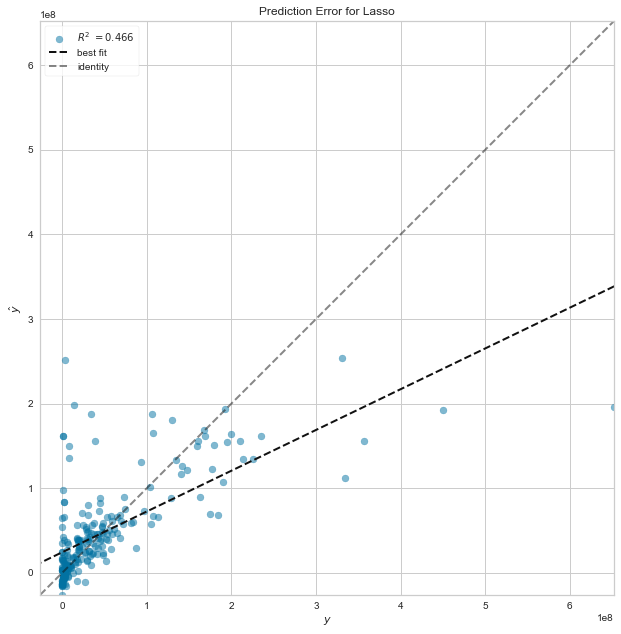

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [212]:
# Create a prediction error visualization

visualizer = PredictionError(lr_lasso, size=(1200, 760), alpha = .5)


visualizer.fit(X.values, y.values)  # Fit the training data to the visualizer
visualizer.score(dfX_test_scaled_drop.values, dfy_test.values)  # Evaluate the model on the test data
visualizer.show()  




<div class="alert alert-block alert-info">
<h3> Conclusions:</h3>
<br>
<span style="font-size:1.2em" >
    <ul>
        <li>Lasso regression with industry recommended features resulted in the best model</li>
        <li>The model does not offer great predictability as a whole</li>
        <li>However, the interaction coefficients might provide some interesting insights into how revenues of films with budgets over $75M differ from films with lower budgets based on the features</li>
    </ul>
</span>
</div>

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


ValueError: x and y must be the same size

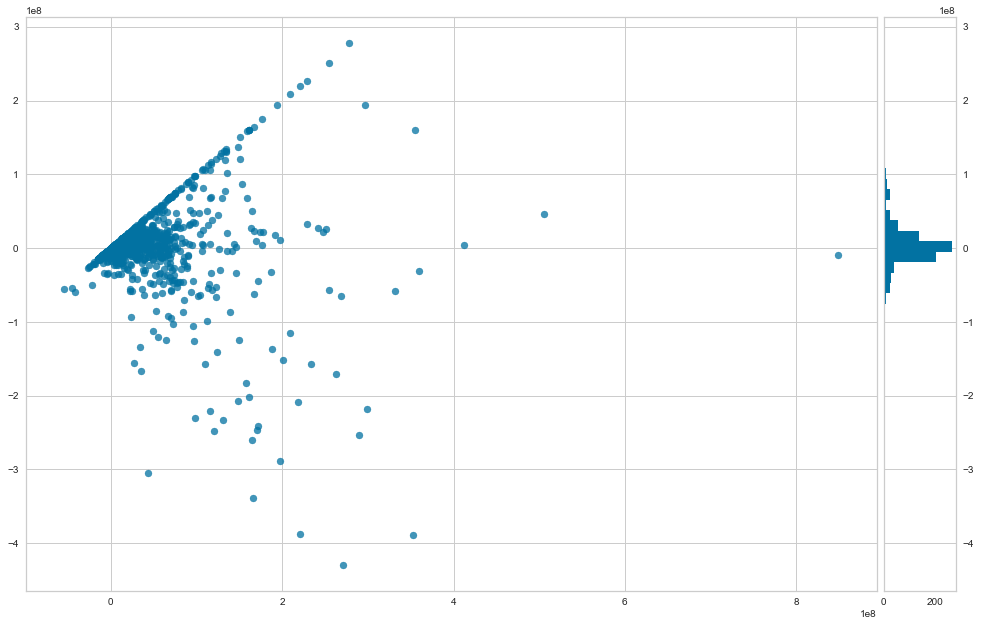

In [80]:
visualizer = ResidualsPlot(lr_lasso, size=(1200, 760), alpha = .5)
visualizer.fit(X.values, y.values)  # Fit the training data to the visualizer
visualizer.score(dfX_test_scaled_drop.values, dfy_test.values)  # Evaluate the model on the test data
visualizer.show()  



/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


ValueError: x and y must be the same size

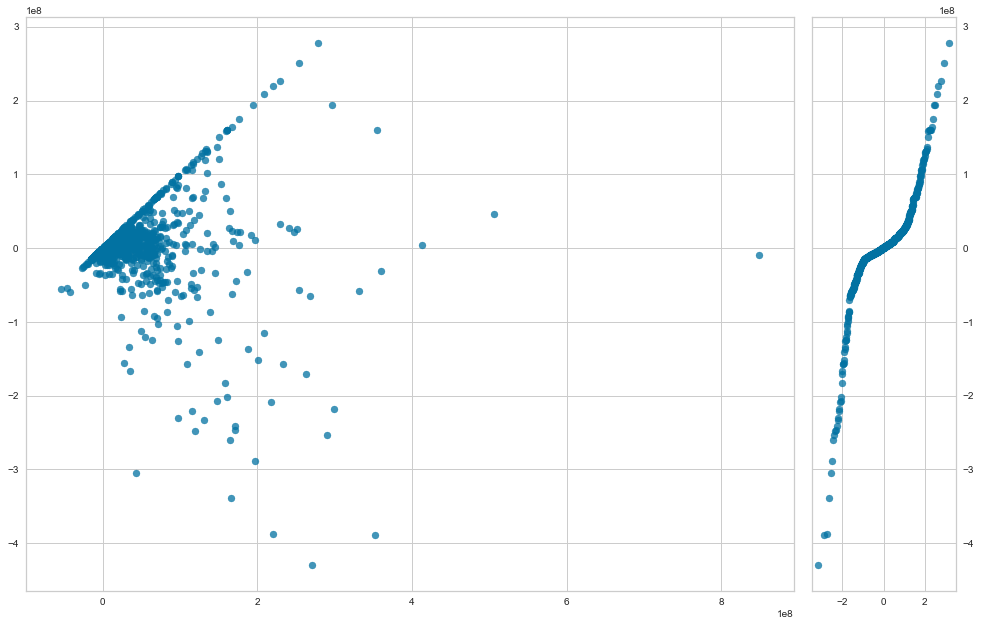

In [81]:
visualizer = ResidualsPlot(lr_lasso, size=(1200, 760), alpha = .5,
                          hist=False, qqplot=True)

visualizer.fit(X.values, y.values)  # Fit the training data to the visualizer
visualizer.score(dfX_test_scaled_drop.values, dfy_test.values)  # Evaluate the model on the test data
visualizer.show()  